In [11]:
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt
import rasterio
import numpy as np
import scipy
import scipy.signal as signal
import netCDF4 as nc
import plotly.express as ex



In [10]:
#load up data

#gradients1_data = pd.read_csv("G1_Metab_Data.csv")
gradients1_metadata = pd.read_csv("G1_MetaData.csv")
peridice_data = pd.read_csv("PERIDICE_metabolite_data.csv")

In [12]:
print(gradients1_data.shape)
print(gradients1_data.columns)
print(peridice_data.columns)
print(gradients1_metadata.columns)

(84, 38)
Index(['Compound_name_in_figures', 'Complete_compound_name', 'S11C1_A',
       'S12C1_A', 'S12C1_B', 'S13C1_A', 'S13C1_B', 'S14C1_A', 'S14C1_B',
       'S14C1_C', 'S2C3_A', 'S4C1_A', 'S4C1_B', 'S4C1_C', 'S4C2_A', 'S4C2_B',
       'S6C1_A', 'S6C1_B', 'S6C1_C', 'S6C2_A', 'S6C2_B', 'S8C1_A', 'S9C1_A',
       'S9C1_B', 'S9C2_A', 'S9C2_B', 'U3_A', 'U3_B', 'U4_A', 'U4_B', 'U6_A',
       'U6_B', 'U7_A', 'U7_B', 'U8_A', 'U8_B', 'U9_A', 'U9_B'],
      dtype='object')
Index(['metabolite', 'treatment', 'date', 'triplicate', 'filename', 'nmol',
       'pc', 'pn', 'nmol_per_pc', 'added_N_uM'],
      dtype='object')
Index(['Sample_ID', 'Binned_latitude', 'Time_UTC', 'NO3_NO2', 'PO4', 'PC_nM',
       'PN_nM'],
      dtype='object')


**NMDS, PCA, Heatmap on Gradients 1 Data**
- PCR component analysis
- And heat map analysis of G1_metab_data.csv
    - Concentrations of metabolites in different areas
    - Do max normalizations on the values

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns

gradients1_data = gradients1_data.dropna()
gradients1_metadata = gradients1_metadata.dropna()
metabolite_columns = gradients1_data.columns[2:]  # Assuming metabolite columns start from the 3rd column

# Aggregate numeric values for duplicate metabolites
aggregated_data = gradients1_data.groupby('Complete_compound_name')[metabolite_columns].mean()

# Merge metabolite data with metadata
merged_data = pd.merge(aggregated_data, gradients1_metadata, left_index=True, right_on='Sample_ID')

# Extract relevant columns for PCR
X_columns = metabolite_columns
nutrients = ['NO3_NO2', 'PO4', 'PC_nM', 'PN_nM']  # Assuming these are your nutrient columns

# Create a DataFrame to store results
results_df = pd.DataFrame(columns=['Nutrient', 'MSE', 'R-squared'])

# Perform PCR for each nutrient
for nutrient in nutrients:
    # Split the data into features (X) and target (y)
    X = merged_data[X_columns]
    y = merged_data[nutrient]

    # Split the data into training and testing sets
    if len(X) < 2:
        print(f"Insufficient data for nutrient {nutrient}. Skipping.")
        continue
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Perform PCA
    pca = PCA(n_components=2)  # You can adjust the number of components
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    # Perform linear regression on principal components
    model = LinearRegression()
    model.fit(X_train_pca, y_train)

    # Make predictions on the test set
    predictions = model.predict(X_test_pca)

    # Evaluate the model
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    # Store results in DataFrame
    results_df = results_df.append({'Nutrient': nutrient, 'MSE': mse, 'R-squared': r2}, ignore_index=True)

    # Plot the original data
    plt.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], color='k', alpha=0.125)
    plt.title(f'PCR: Original Data - Nutrient: {nutrient}')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

    # Plot the principal components
    plt.plot([0, pca.components_[0, 0]], [0, pca.components_[0, 1]], '-', color='cyan', linewidth=2)
    plt.plot([0, pca.components_[1, 0]], [0, pca.components_[1, 1]], '-', color='white', linewidth=2)
    plt.title(f'PCR: Principal Components - Nutrient: {nutrient}')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

# Print results
print(results_df)

# Create a heatmap of the results
heatmap_data = results_df.pivot('Nutrient', 'MSE', 'R-squared')
sns.heatmap(heatmap_data, annot=True, cmap='viridis', cbar_kws={'label': 'R-squared'})
plt.title('PCR: R-squared Heatmap for Each Nutrient')
plt.show()

Insufficient data for nutrient NO3_NO2. Skipping.
Insufficient data for nutrient PO4. Skipping.
Insufficient data for nutrient PC_nM. Skipping.
Insufficient data for nutrient PN_nM. Skipping.
Empty DataFrame
Columns: [Nutrient, MSE, R-squared]
Index: []


TypeError: pivot() takes 1 positional argument but 4 were given

In [25]:
common_columns = set(gradients1_data.columns) & set(gradients1_metadata.columns)
print("Common columns for merging:", common_columns)

# Assuming 'Sample_ID' is the common column for merging
merged_data = pd.merge(aggregated_data, gradients1_metadata, left_index=True, right_on='Sample_ID')

# Display the first few rows of the merged data for inspection
print("Merged data:")
print(merged_data.head())

Common columns for merging: set()
Merged data:
Empty DataFrame
Columns: [S11C1_A, S12C1_A, S12C1_B, S13C1_A, S13C1_B, S14C1_A, S14C1_B, S14C1_C, S2C3_A, S4C1_A, S4C1_B, S4C1_C, S4C2_A, S4C2_B, S6C1_A, S6C1_B, S6C1_C, S6C2_A, S6C2_B, S8C1_A, S9C1_A, S9C1_B, S9C2_A, S9C2_B, U3_A, U3_B, U4_A, U4_B, U6_A, U6_B, U7_A, U7_B, U8_A, U8_B, U9_A, U9_B, Sample_ID, Binned_latitude, Time_UTC, NO3_NO2, PO4, PC_nM, PN_nM]
Index: []

[0 rows x 43 columns]


**Multiple Linear Regression**

Mean Squared Error (NO3_NO2): 1.838741730728795
R-squared (NO3_NO2): 0.7434509200811186


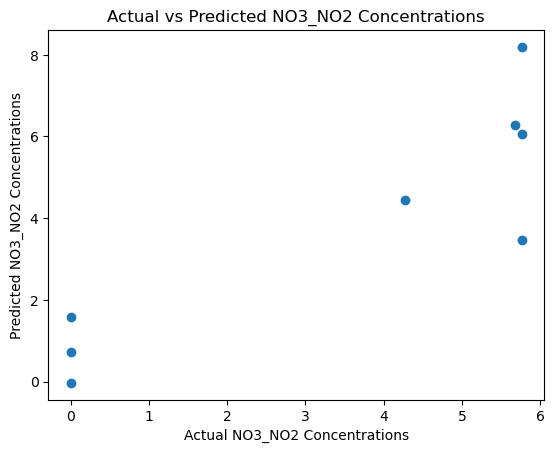

Mean Squared Error (PO4): 0.00985893682561436
R-squared (PO4): 0.7821190067773189


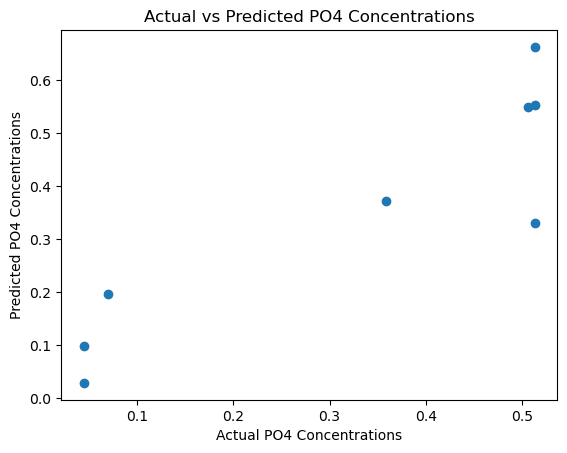

Mean Squared Error (PC_nM): 180190.70511448197
R-squared (PC_nM): 0.8693582431043649


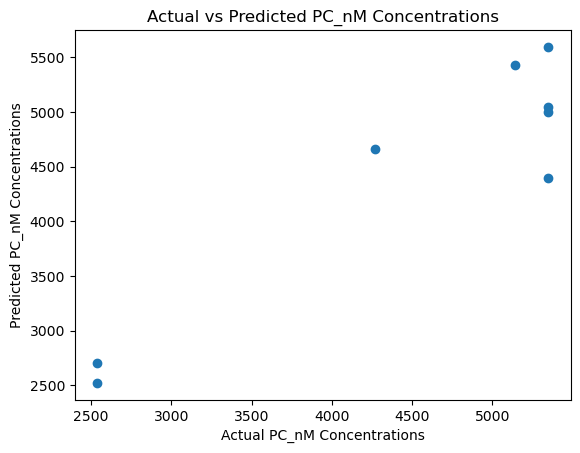

Mean Squared Error (PN_nM): 9348.351905385416
R-squared (PN_nM): 0.8693195024474878


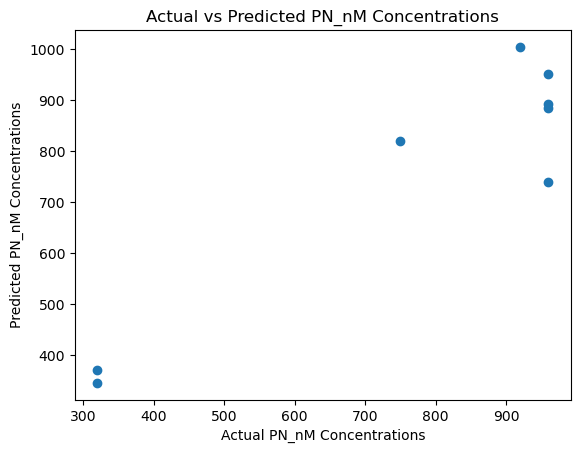

In [20]:
#selecting nutrients to predict
gradients1_data = gradients1_data.dropna()
gradients1_metadata = gradients1_metadata.dropna()

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

sample_ids = gradients1_data.columns[2:]

sample_ids_df = pd.DataFrame({'Sample_ID': sample_ids})

merged_data = pd.merge(sample_ids_df, gradients1_metadata, left_on='Sample_ID', right_on='Sample_ID', how='inner')

X = gradients1_data.set_index('Complete_compound_name').loc[:, sample_ids].T
y = merged_data[['NO3_NO2', 'PO4', 'PC_nM', 'PN_nM']]

for nutrient in ['NO3_NO2', 'PO4', 'PC_nM', 'PN_nM']:
    y_current = y[nutrient]
    X_train, X_test, y_train, y_test = train_test_split(X, y_current, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = LinearRegression()
    model.fit(X_train_scaled, y_train)

    predictions = model.predict(X_test_scaled)

    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    print(f'Mean Squared Error ({nutrient}): {mse}')
    print(f'R-squared ({nutrient}): {r2}')

    plt.scatter(y_test, predictions)
    plt.xlabel(f'Actual {nutrient} Concentrations')
    plt.ylabel(f'Predicted {nutrient} Concentrations')
    plt.title(f'Actual vs Predicted {nutrient} Concentrations')
    plt.show()